- $W$: matrix of (thresholded) weights
- $\gamma$: decay parameter

NMPH function
$$
\text{NMPH}(x) = \begin{cases}
2 x \cdot y_{min}/x_{cp} & x \leq x_{\text{cp}/2}\\
2 x \cdot (y_{cp} - y_{min})/x_{cp} & x_{\text{cp}/2} < x \leq x_{\text{cp}}\\
x \cdot (y_{max} - y_{cp})/(1 - x_{\text{cp}}) & x_{\text{cp}} < x \leq 1
\end{cases}
$$

Weight update
$$W^{t+1}_{k-1,k} = \Delta_{k-1,k}W^t_{k-1, k}$$

Sigmoid
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

Let $W_0, \text{ACT}_0$ be the initial conditions

$$
\text{ACT}_k = \sigma\left(\sum_{i=1}^{k}\gamma^i\prod_{d=1}^{i}\sigma\left(W_{d-1} + \text{NMPH}(\text{ACT}_{d-1})\right)\right)\\
$$

$$
\Delta W_d = \sigma\left(W_{d-1} + \text{NMPH}(\text{ACT}_{d-1})\right)
$$

$$
\text{ACT}_k = \sigma\left(\sum_{i=1}^{k}\gamma^i\prod_{d=1}^{i}\Delta W_d\right)\\
$$

In [19]:
import sys
sys.path.insert(1, '../')
from graphsemnet.gsn import compute_nmph, simulate_distance_matrix, normalize_distance_matrix
from scipy.special import expit
import numpy as np

In [687]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [20]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [21]:
W = simulate_distance_matrix(100, 10, 10)

In [22]:
W -= W.min()
W /= (W.max() - W.min())

In [23]:
W[np.tril_indices_from(W)] = 0.

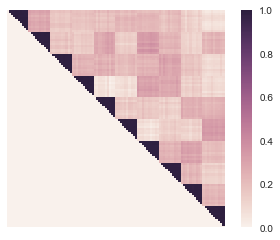

In [24]:
sns.heatmap(W, xticklabels=False, yticklabels=False, square=True)

In [25]:
n_nodes = len(W)

In [1105]:
nmph = compute_nmph(-0.1, 0.5, 0.5, 0.6)

In [1106]:
x = np.linspace(0, 1, 100)
y = nmph(x)

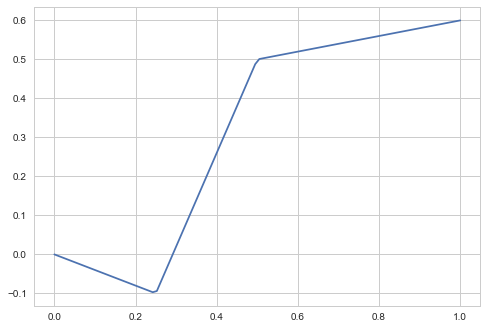

In [1107]:
plt.plot(x, y)

In [ ]:
np.max()

In [1213]:
#def my_expit(x, mult=10, mu=0.5):
#    return expit((x-mu)*mult)

def my_expit(x):
    return np.clip(x, 0, 1)

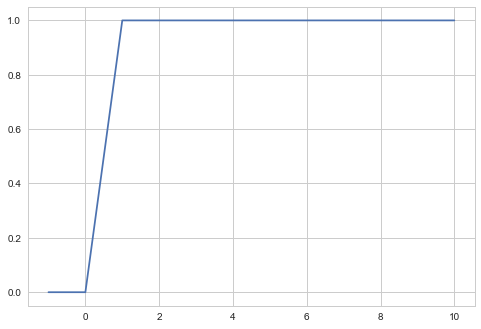

In [1214]:
x = np.linspace(-1, 10, 100)
plt.plot(x, my_expit(x))

In [1215]:
gamma = 0.1

In [1042]:
W_thresh = W.copy()
W_thresh[W_thresh <= 0.3] = 0.

$$
W_d = f\left(W_{d-1} + h(\text{ACT}_{d-1}^{T}) \circ A \right)
$$

$$
\text{ACT}_k =  f\left(\sum_{i=0}^{k-1}\gamma^i\text{ACT}_{i}\cdot\prod_{d=0}^{i}W_d\right) \\
$$

$\Pi$ denotes element-wise multiplication

$\cdot$ denotes dot-product

$\text{ACT}_i$ is a row vector

$f(x)$ is an activation function, in our case a ReLU

In [1212]:
# Todo: extend this with R^i to model second, and third, etc reachability

In [1190]:
def rect(x):
    return np.clip(x, 0, 1.)

def spread_activation(W0, ACT0, nmph, gamma, d, A):
    """Spread activation with NMPH on a graph with initial weight W0, and activation ACT0
    
    Arguments
    ---------
    W0 : array (n_nodes, n_nodes)
        initial weights of the graph
    ACT0 : array (1, n_nodes)
        row array of initial activations
    npmh : function [0, 1] -> [-1, 1]
        nmph function, generated with `compute_nmph
    gamma : float [0, 1]
        decay parameter
    d : int
        how far the activation is allowed to spread
    
    Returns
    -------
    Ws : list of arrays (n_nodes, n_nodes)
    ACT : list of arrays 
        activations for every depth
    """
    # initialize values
    assert(ACT0.ndim == 2 and (ACT0.shape[0] <= ACT0.shape[1]))
    Ws = [W0]
    ACT = [ACT0]
    dW = np.zeros(ACT0.shape)

    # loop 
    for i in range(d):
        # update W
        W_i = rect(Ws[-1] + nmph(ACT[-1]).T * A)
        Ws.append(W_i)
        # update ACT
        dW += gamma**i * np.dot(ACT[i], np.multiply.reduce(Ws))
        ACT_ = rect(dW)
        ACT.append(ACT_)
    return Ws, ACT

In [1191]:
def myheatmap(W, cbar=True, ax=None, annot=None):
    ax = sns.heatmap(W, cbar=cbar, square=True, annot=annot, vmin=0, vmax=1, ax=ax)
    return ax

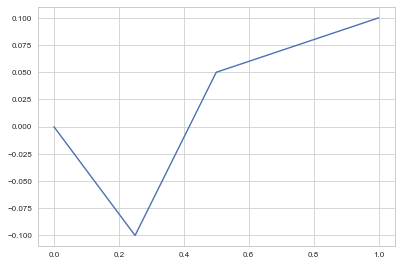

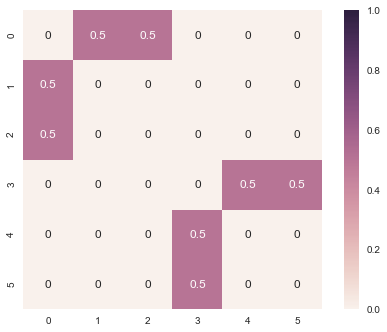

In [1193]:
ax = myheatmap(W, annot=True);

In [1217]:
def noisy_activation(act, sigma_noise=0.1):
    act = np.array(act)
    return rect(act + np.random.normal(scale=sigma_noise, size=act.shape))

In [1218]:
def filter_activation(activation, nmph):
    a = activation.copy()
    a = rect(nmph(a))
    a /= a.sum()
    return a.flatten()

In [1219]:
gamma = 0.3
depth = 1
n_iter = 1000
sigma_noise = 0.01

In [1220]:
a = noisy_activation([1, 0, 0, 0])
print(a)
print(nmph(a))
print(rect(nmph(a)))

[ 0.89000622  0.03075047  0.03776024  0.        ]
[ 0.33400373 -0.01230019 -0.01510409  0.        ]
[ 0.33400373  0.          0.          0.        ]


In [1294]:
def run_experiment(gamma, depth, nmph, n_iter=1000, sigma_noise=0.01):
    winner_iter = []
    # Phase 1: Study
    W = np.zeros((6, 6))
    W[0, 1] = 0.5
    W[0, 2] = 0.5

    W[3, 4] = 0.5
    W[3, 5] = 0.5
    W += W.T

    # adjacency please
    A = compute_adjacency(W)

    for i in range(n_iter):
        # Phase 2: Retrieval Practice
        # We want horse
        ACT_pr = np.array([1, .25, 0, 0, 0, 0])[None, :] # we want a row vector
        # Add noise on activation
        ACT_pr = noisy_activation(ACT_pr, sigma_noise=sigma_noise)
        W_ = W
        for _ in range(1):
            Ws, ACT = spread_activation(W_, ACT_pr, nmph, gamma, depth, A)
            W_ = Ws[-1]

        # Phase 3: Test
        W_te = Ws[-1]
        ACT_rpplus = noisy_activation(np.array([1, .1, 0, 0, 0, 0])[None, :], sigma_noise)
        ACT_rpminus = noisy_activation(np.array([1, 0, .1, 0, 0, 0])[None, :], sigma_noise)
        ACT_nrp1 = noisy_activation(np.array([0, 0, 0, 1, .1, 0])[None, :], sigma_noise)
        ACT_nrp2 = noisy_activation(np.array([0, 0, 0, 1, 0, .1])[None, :], sigma_noise)

        winners = []
        for activation, which in zip([ACT_rpplus, ACT_rpminus, ACT_nrp1, ACT_nrp2], [1, 2, 4, 5]):
            _, activation_ = spread_activation(W_te, activation, nmph, gamma, depth, A)
            # do not consider the one we activated
            which_active = np.argmax(activation)
            last_activation = activation_[-1]
            # do not look at the category we ping'd
            last_activation[0][which_active] = 0.
            #prob_activation = filter_activation(last_activation, nmph)
            # probabilistic response
            #n_responses = 10
            #responses = np.random.choice(range(6), n_responses, p=prob_activation)
            #winners.append(np.sum(responses == which)/n_responses)
            winners.append((np.argmax(nmph(last_activation)) == which).astype(int))
            #winners.append((activation_[-1][which] > 0.5).astype(int))
        winner_iter.append(winners)

    winner_iter = np.array(winner_iter)

    #rpplus = np.sum(winner_iter[:, 0] == 1)/n_iter
    #rpminus = np.sum(winner_iter[:, 1] == 2)/n_iter
    #nrp = (np.sum(winner_iter[:, 2] == 4)/n_iter + np.sum(winner_iter[:, 3] == 5)/n_iter)/2.
    return winner_iter

In [1297]:
exp = run_experiment(0.8, 3, nmph, n_iter=100)

In [1298]:
exp

array([[1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0,

In [1234]:
gammas = np.linspace(0.1, 1, 10)
depths = np.arange(1, 4)

In [1235]:
from itertools import product, islice

In [1237]:
exps = []
for i, (gamma, d) in enumerate(product(gammas, depths)):
    if i % 10 == 0:
        print(i), 
    exps.append(np.mean(run_experiment(gamma, d, nmph), axis=0))

0
10
20


In [1280]:
def cost_function(exp):
    rp_plus = exp[0]
    rp_minus = exp[1]
    nrp = np.mean(exp[2:])
    cost = (rp_plus/rp_minus) + (nrp/rp_minus) + (rp_plus/nrp)
    return 0 if cost == np.inf else cost

In [1250]:
cost = list(map(lambda x: cost_function(x), exps))

In [1254]:
idx_win = np.argmax(cost)

In [1255]:
cost[idx_win]

3.0275434424394021

In [1256]:
list(product(gammas, depths))[idx_win]

(0.30000000000000004, 2)

In [1258]:
rp_plus = exps[idx_win][0]
rp_minus = exps[idx_win][1]
nrp = np.mean(exps[2:])

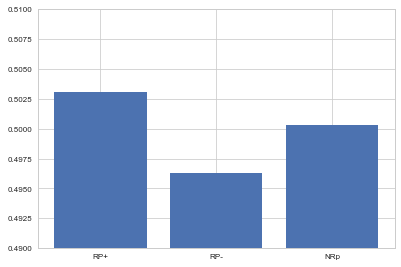

In [1321]:
fig, ax = plt.subplots(1, 1)
ax.bar([0, 1, 2], [rp_plus, rp_minus, nrp], tick_label=['RP+', 'RP-', 'NRp'])
ax.set_ylim([.49, .51]);

In [1262]:
# So these are the parameters we want to keep for gamma and d
gamma, d = list(product(gammas, depths))[idx_win]
print(gamma, d)

0.3 2


In [1263]:
from joblib.parallel import Parallel, delayed

In [1266]:
def compute_onefold(gamma, depth, args_):
    exps = []
    for arg in args_:
        nmph = compute_nmph(*arg)
        exp = run_experiment(gamma, depth, nmph)
        exps.append(exp.mean(axis=0))
    return exps

In [1267]:
# Now we can try to find a good nmph
# this is what we used before: nmph = compute_nmph(-0.1, .5, .1, .4)
n_steps = 5
min_y = np.linspace(-0.4, 0, n_steps)
inflection_x = np.linspace(0.3, 0.6, n_steps)
inflection_y = np.linspace(0, 0.3, n_steps)
y_max = np.linspace(0.5, 0.8, n_steps)

# get all the values
vals = product(min_y, inflection_x, inflection_y, y_max)

n_jobs = 4
step = -(-n_steps**4 // n_jobs)

exps = Parallel(n_jobs=n_jobs)(delayed(compute_onefold)
                          (0.1, 2, islice(vals, step)) for _ in range(n_jobs))
# for i, (gamma, d) in enumerate(product(gammas, depths)):
#     if i % 10 == 0:
#         print(i), 
#     exps.append(run_experiment(gamma, d))

/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in less
/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in less
/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in less
/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encounter

In [1272]:
exps = np.vstack(exps)

In [1281]:
exps_cost = np.array(list(map(lambda x: cost_function(x), exps)))

/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars


In [1282]:
np.max(exps_cost)

3.7696109094491801

In [1284]:
win = np.argmax(exps_cost)

In [1285]:
param_win = list(product(min_y, inflection_x, inflection_y, y_max))[win]

In [1286]:
param_win

(-0.40000000000000002, 0.59999999999999998, 0.22499999999999998, 0.5)

In [1287]:
exps[win]

array([ 0.4902,  0.5065,  0.2025,  0.2063])

In [1301]:
gamma = 0.3 
depth = 3

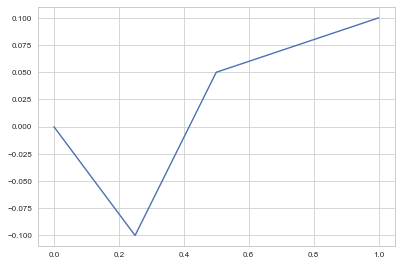

In [1315]:
nmph = compute_nmph(-0.1, .5, .05, .1)
x = np.linspace(0, 1, 1000)
y = nmph(x)
plt.plot(x, y);

In [1316]:
winner_iter = []
# Phase 1: Study
W = np.zeros((6, 6))
W[0, 1] = 0.5
W[0, 2] = 0.5

W[3, 4] = 0.5
W[3, 5] = 0.5
W += W.T

# adjacency please
A = compute_adjacency(W)
n_iter = 1

for i in range(n_iter):
    # Phase 2: Retrieval Practice
    # We want horse
    ACT_pr = np.array([1, .25, 0, 0, 0, 0])[None, :] # we want a row vector
    # Add noise on activation
    ACT_pr = noisy_activation(ACT_pr, sigma_noise=sigma_noise)
    W_ = W
    for _ in range(1):
        Ws, ACT = spread_activation(W_, ACT_pr, nmph, gamma, depth, A)
        W_ = Ws[-1]

    # Phase 3: Test
    W_te = Ws[-1]
    ACT_rpplus = noisy_activation(np.array([1, .1, 0, 0, 0, 0])[None, :], sigma_noise)
    ACT_rpminus = noisy_activation(np.array([1, 0, .1, 0, 0, 0])[None, :], sigma_noise)
    ACT_nrp1 = noisy_activation(np.array([0, 0, 0, 1, .1, 0])[None, :], sigma_noise)
    ACT_nrp2 = noisy_activation(np.array([0, 0, 0, 1, 0, .1])[None, :], sigma_noise)

    winners = []
    for activation, which in zip([ACT_rpplus, ACT_rpminus, ACT_nrp1, ACT_nrp2], [1, 2, 4, 5]):
        _, activation_ = spread_activation(W_te, activation, nmph, gamma, depth, A)
        # do not consider the one we activated
        which_active = np.argmax(activation)
        last_activation = activation_[-1].copy()
        # do not look at the category we ping'd
        last_activation[0][which_active] = 0.
        #prob_activation = filter_activation(last_activation, nmph)
        # probabilistic response
        #n_responses = 10
        #responses = np.random.choice(range(6), n_responses, p=prob_activation)
        #winners.append(np.sum(responses == which)/n_responses)
        winners.append((np.argmax(nmph(last_activation)) == which).astype(int))
        #winners.append((activation_[-1][which] > 0.5).astype(int))
    winner_iter.append(winners)

winner_iter = np.array(winner_iter)


In [1317]:
sns.set_context('paper')

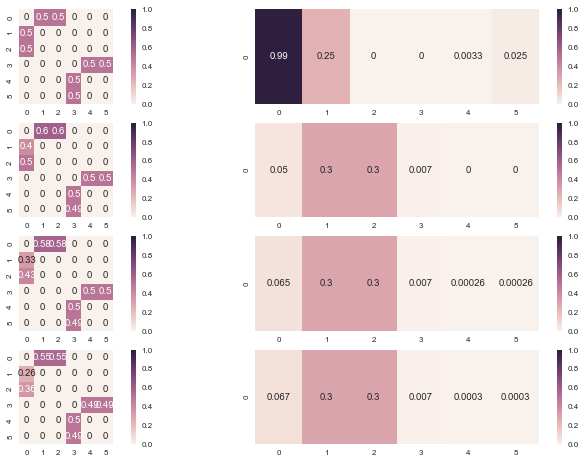

In [1318]:
n_depth = len(Ws)
fig, axs = plt.subplots(n_depth, 2, figsize=(14, 8))
for W_, ACT_, ax in zip(Ws, ACT, axs):
    sns.heatmap(W_, annot=True, vmin=0, vmax=1, ax=ax[0], square=True)
    sns.heatmap(ACT_, annot=True, vmin=0, vmax=1, ax=ax[1])